## Campaign Conversion Target with Uplift Modeling

Uplift modeling, also known as incrementality modeling or persuasion modeling, models the causal effect of a treatment on the outcome for different individuals. Uplift modeling has been widely applied in marketing, personalized medicine, and political elections, scenarios in which you don’t simply want to predict an outcome, but predict how that outcome might change with respect to a treatment.<br>

*Uplift modeling is an important yet novel area of research in machine learning which aims to explain and to estimate the causal impact of a treatment at the individual level.*

<img src="uplift-treatmentvsresponse.jpg" alt="Uplift Model-TreatmentvsResponse" title="Uplift Model - Treatment vs Response" style="width: 400px;"/>

In the digital advertising industry, the treatment is exposure to different ads and uplift modeling is used to direct marketing efforts towards users for whom it is the most efficient. One of the main applications of the Machine Learning models is to improve Targeted Marketing. Targeted Marketing is used to select the customers that most likely buy a product.

There are different approaches for Targeted Marketing such as the Classical modeling (also known as Response model). This approach is focused on training a model with customers that were sent a promotion/offer. The model separates the customers that will buy from the ones that will not buy if targeted. This approach generates higher profit than random selection targeting.

Classical modeling has a flaw. It does not separate customers that will buy even if not targeted from the ones that will only buy if targeted. In other words, the model wastes money by targeting customers that do not need it. The current solution to that issue is the Uplift modeling.

Uplift modeling can separate customers that will buy if not targeted from the ones that will buy only if targeted, as well as avoiding customers that will not buy even if targeted. Specifically, the model identifies the customers that are worth spending money on Targeted Marketing.


> **When should we use uplift modeling?**<br>
Uplift modeling is used when the customer’s target action is likely to happen without any communication. For instance, we want to promote a popular product but we don’t want to spend our marketing budget on customers who will buy the product anyway with or without communication. If the product is not popular and it has to be promoted to be bought, then a task turns to the response modeling task

> The Uplift model evaluates the net effect of communication by trying to select only those customers who are going to perform the target action only when there is some advertising exposure presenting to them. The model predicts a difference between the customer’s behavior when there is a treatment (communication) and when there is no treatment (no communication).

<font color=blue>
Uplift modeling, also known as incremental modeling, true lift modeling, or net modeling is a predictive modeling technique that directly models the incremental impact of a treatment (such as a direct marketing action) on an individual's behavior.


The goal of uplift modeling, also known as net lift or incremental response modeling, 
- is to identify the “persuadables”, 
- not waste efforts on “sure things” and “lost causes”, 
- and avoid bothering “sleeping dogs”, or those who would react negatively to the treatment, if they exist.


Let's generate a model that can identify users that are more likely to convert (or buy the product) and avoid the ones that are not.
</font>

### Uplift modeling using Advertising Data

We are working with a dataset that is constructed by assembling data resulting from several incrementality tests, a particular randomized trial procedure where a random part of the population is prevented from being targeted by advertising. It consists of 13M rows, each one representing a user with 11 features, a treatment indicator and 2 labels (visits and conversions).

> **Dataset source**
https://ailab.criteo.com/criteo-uplift-prediction-dataset/ <br>
The dataset is a collection of 13 million samples from a randomized control trial, scaling up previously available datasets by a healthy 590x factor. <br>
The data was provided by AI lab of Criteo (French advertising company that provides online display advertisements). The data contains 13 million instances from a randomized control trial collected in two weeks, where 84.6% of the users where sent the treatment.

Each instance has 12 features that were anonymized plus a treatment variable and two target variables (visits and conversion). There is another extra variable called "exposure" which indicates whether the user was effectively exposed to the treatment.
The dataset consists of 13M rows, each one representing a user with 12 features, a treatment indicator and 2 binary labels (visits and conversions). Positive labels mean the user visited/converted on the advertiser website during the test period (2 weeks). The global treatment ratio is 84.6%. It is usual that advertisers keep only a small control population as it costs them in potential revenue.
Following is a detailed description of the features:
 - f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11: feature values (dense, float)
 - treatment: treatment group (1 = treated, 0 = control)
 - conversion: whether a conversion occurred for this user (binary, label)
 - visit: whether a visit occurred for this user (binary, label)
 - exposure: treatment effect, whether the user has been effectively exposed (binary)

<font color=red>
There are two target variables (visits and conversion), this notebook will only focus on the conversion variable, which can be understood as the indicator whether the user bought the product. <br>
The goal is to generate a model that can identify users that are more likely to convert (or buy the product) and avoid the ones that are not.
</font>

Import the necessary libraries that we will use 

In [1]:
#EDA
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style

#Preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from imblearn.pipeline import Pipeline

#Machine Learning
from sklearn.linear_model import LogisticRegression
from causallift import CausalLift
import xgboost
import lightgbm as lgb
from lightgbm import LGBMClassifier

#Evaluation
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

#Uplift
from sklift.models import TwoModels
from sklift.models import SoloModel
from sklift.models import ClassTransformation
from sklift.metrics import qini_auc_score
from sklift.viz import plot_qini_curve
from sklift.viz import plot_uplift_curve
from sklift.viz import plot_uplift_by_percentile

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

C:\Program Files\Python310\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


#### Data Analysis

In [2]:
#Read the dataset
df = pd.read_csv("criteo-uplift-data.csv")

In [3]:
#Given the treatment, exposure and visits, how is the conversion?
df.groupby(['treatment','exposure','visit']).agg({'conversion':['mean','sum','count']})

conversion                 
                               mean    sum     count
treatment exposure visit                            
0         0        0       0.000000      0   2016832
                   1       0.050721   4063     80105
1         0        0       0.000000      0  11055129
                   1       0.034259  13680    399314
          1        0       0.000000      0    250702
                   1       0.129745  23031    177510

**Observation**<br>
Rate of conversion among untreated (treatment=0) and unexposed (exposed=0) candidates is higher (5%) than the <br>
rate of conversion among treated (treatment=1) but unexposed (exposed=1), viz (3%).<br>
Rate of conversion among treated (treatment=1) and exposed (exposed=1) candidates is the highest (12.9%).<br>

<font color='red'>
This clearly outlines the fact that the treatment is ineffective if candidates are treated to the campaign but are not effectively exposed to it.
</font>

**Our model is more effective when conversion rates are modeled on exposed candidates.**<br>
Let's drop candidates who are treated but not effective exposed.

In [4]:
users_to_remove = df[(df['treatment'] == 1 ) & (df['exposure']==0)]

#New df where treatment column is dropped
df_ml = df.drop(users_to_remove.index).reset_index().drop(['index','treatment', 'visit'], axis = 1)

<AxesSubplot:>

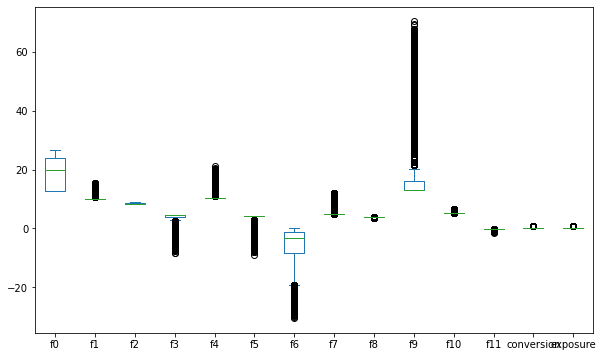

In [5]:
df_ml.plot.box(figsize=(10,6))

#### For effective modeling, let's scale the feature set

In [6]:
#Scale the feature set
scaled = preprocessing.StandardScaler()
df_sca = scaled.fit_transform(df_ml.drop(['conversion','exposure'], axis=1))

#df_sca = pd.DataFrame(data=scaled, columns = df_ml.drop(['conversion','exposure'], axis = 1).columns)
df_exposure = df_ml['exposure']
df_conversion = df_ml['conversion']

#### Exposed flag is our new Treatment indicator

In [7]:
X=pd.DataFrame(df_sca.tolist())
treatment = df_ml['exposure']
y = df_ml['conversion']

#### Let's look at our scaled features

<AxesSubplot:>

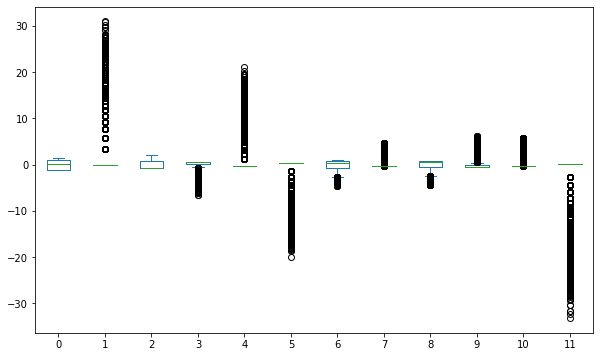

In [8]:
X.plot.box(figsize=(10,6))

#### Split dataset into a Train & Test set, stratified over Treatment (i.e. Exposed flag)

In [9]:
X_train, X_test, treatment_train, treatment_test, y_train, y_test = train_test_split(X,treatment,y, random_state=23, stratify=treatment, test_size=0.33)

#### scikit-uplift

scikit-uplift (sklift) is an uplift modeling python package that provides fast sklearn-style models implementation, evaluation metrics and visualization tools.
<br>
The main idea is to provide easy-to-use and fast python package for uplift modeling. It delivers the model interface with the familiar scikit-learn API. One can use any popular estimator (for instance, from the Catboost library).
<br>
Uplift modeling estimates a causal effect of treatment and uses it to effectively target customers that are most likely to respond to a marketing campaign.

### Implementing Two Model Approach

The main idea is to estimate the conditional probabilities of the treatment and control groups separately.

Train the first model using the treatment set.

Train the second model using the control set.

Inference: subtract the control model scores from the treatment model scores.

<img src="uplift-2model-calc.jpg" alt="Uplift Model-TwoModelCalc" title="Uplift Model - Two Model Approach" style="width: 500px;"/>

###### Hyperparameter tuning was applied using GridSearchCV on multiple models, to conclude optimum performance with Logistic Regression.

In [10]:
treatment_model = LogisticRegression(C= 0.00001, penalty= 'elasticnet', solver= 'saga', l1_ratio=0.1, random_state=23)
control_model = LogisticRegression(C= 0.00001, penalty= 'elasticnet', solver= 'saga', l1_ratio=0.1, random_state=23)
LogReg = TwoModels(estimator_trmnt = treatment_model, estimator_ctrl = control_model, method='vanilla')

In [11]:
logreg_tm = LogReg.fit(X_train, y_train, treatment_train)
uplift_logreg = logreg_tm.predict(X_test)
# AUQC = area under Qini curve = Qini coefficient
auqc = qini_auc_score(y_test, uplift_logreg, treatment_test) 
print(f"Qini coefficient on full data: {auqc:.4f}")

Qini coefficient on full data: 0.7089


#### Plot the Qini Curve to show uplift

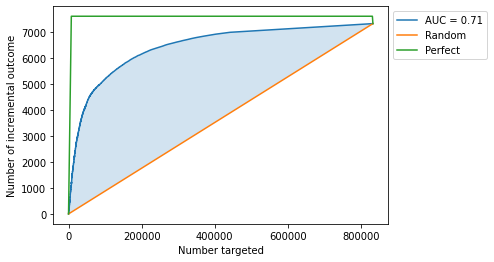

In [12]:
# with ideal Qini curve (red line)
# perfect=True

plot_qini_curve(y_test, uplift_logreg, treatment_test, perfect=True);

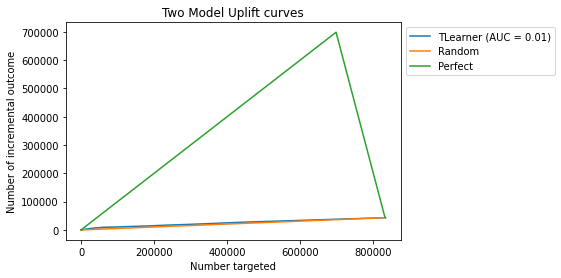

In [13]:
fig, ax = plt.subplots(1, 1)
ax.set_title('Two Model Uplift curves')
plot_uplift_curve(y_test, uplift_logreg, treatment_test,perfect=True, name='TLearner', ax=ax);

C:\Program Files\Python310\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


array([<AxesSubplot:title={'center':'Uplift by percentile\nweighted average uplift = 0.0519'}>,
       <AxesSubplot:title={'center':'Response rate by percentile'}, xlabel='Percentile'>],
      dtype=object)

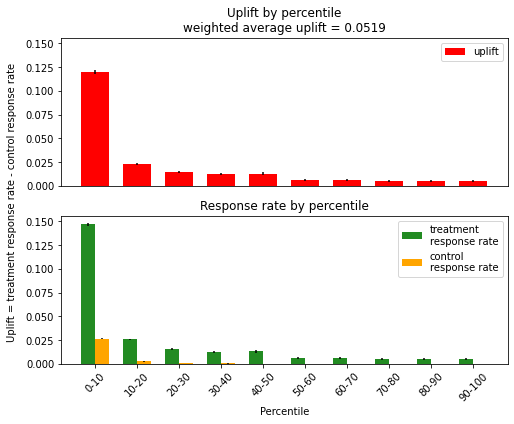

In [14]:
plot_uplift_by_percentile(y_true=y_test, uplift=uplift_logreg, treatment=treatment_test, kind='bar')

### Check Uplift on Test set

In [15]:
X_test['uplift'] = uplift_logreg.tolist()

In [16]:
# sort our test data
X_test.sort_values('uplift', ascending=False, inplace=True)
X_test.reset_index(drop=True, inplace=True)

In [17]:
X_test.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,uplift
833295,-0.893973,-0.154119,-0.804786,-0.777991,-0.213038,0.264136,-0.145959,-0.290197,0.752865,-0.484372,-0.243674,0.138856,0.035551
833296,-1.157336,-0.154119,-0.804786,0.084223,-0.213038,0.264136,-1.165108,-0.290197,0.752865,-0.484372,-0.243674,0.138856,0.035551
833297,-1.193801,-0.154119,-0.804786,-1.326476,-0.213038,0.264136,-0.277649,-0.290197,0.752865,-0.484372,-0.243674,0.138856,0.035551
833298,0.583292,-0.154119,-0.804786,0.496826,-0.213038,0.264136,0.354698,-0.290197,0.752865,-0.484372,-0.243674,0.138856,0.035551
833299,0.672371,-0.154119,-0.804786,0.496826,-0.213038,0.264136,0.723666,-0.290197,0.752865,-0.484372,-0.243674,0.138856,0.035551


In [18]:
X_test['uplift'].describe()

count    833300.000000
mean          0.040137
std           0.027950
min           0.035551
25%           0.035551
50%           0.035603
75%           0.036440
max           0.961477
Name: uplift, dtype: float64

### Predict Uplift on Train Set

In [19]:
# Predict Uplift of Training Set
uplift_Xtrain = logreg_tm.predict(X_train)

In [20]:
X_train['uplift'] = uplift_Xtrain.tolist()

In [21]:
# sort our train data
X_train.sort_values('uplift', ascending=False, inplace=True)
X_train.reset_index(drop=True, inplace=True)

In [22]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,uplift
0,-1.205656,-0.154119,-0.154996,0.496826,20.333346,0.264136,1.016531,-0.290197,-4.038440,5.143014,1.144352,-30.414533,0.966167
1,-0.846677,-0.154119,0.142482,-2.838010,18.019374,0.264136,-1.350536,-0.290197,-3.681941,5.717501,1.720078,-33.139106,0.965686
2,-1.013998,3.326740,-0.593703,-2.386263,17.614019,-3.566604,-1.857975,1.824583,-3.723452,5.641278,1.552527,-31.652118,0.958175
3,-0.819465,3.326740,-0.643830,-3.029921,19.503846,-1.430994,-2.515746,1.814518,-3.992328,5.308735,0.109573,-28.978349,0.956747
4,-0.578404,-0.154119,-0.630838,-1.680914,19.470730,-3.566604,-1.794513,2.557228,-3.855794,5.015487,0.116932,-28.978349,0.956132


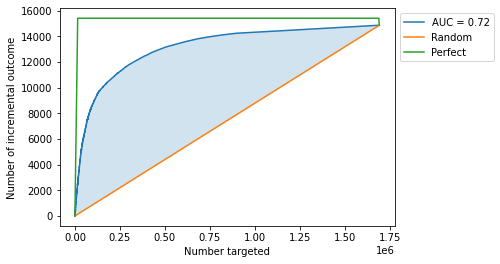

In [23]:
plot_qini_curve(y_train, uplift_Xtrain, treatment_train, perfect=True);

In [24]:
X_train['uplift'].describe()

count    1.691849e+06
mean     4.013945e-02
std      2.802132e-02
min      3.555106e-02
25%      3.555106e-02
50%      3.560328e-02
75%      3.642886e-02
max      9.661668e-01
Name: uplift, dtype: float64

C:\Program Files\Python310\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


array([<AxesSubplot:title={'center':'Uplift by percentile\nweighted average uplift = 0.0518'}>,
       <AxesSubplot:title={'center':'Response rate by percentile'}, xlabel='Percentile'>],
      dtype=object)

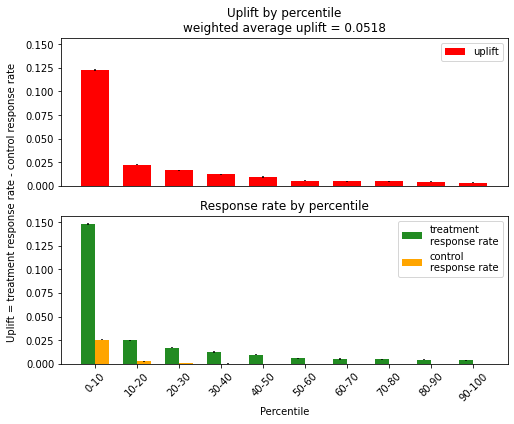

In [25]:
plot_uplift_by_percentile(y_true=y_train, uplift=uplift_Xtrain, treatment=treatment_train, kind='bar')

Save model to Disk using Pickle

In [26]:
import pickle
# save the model to disk
filename = 'uplift_model.sav'
pickle.dump(logreg_tm, open(filename, 'wb'))

In [27]:
new_data = df[(df['treatment'] == 1 ) & (df['exposure']==0)]

In [28]:
new_data_features = new_data.reset_index().drop(['index','treatment', 'visit', 'conversion', 'exposure'], axis = 1)

In [29]:
new_data_features

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679
...,...,...,...,...,...,...,...,...,...,...,...,...
11454438,17.839167,10.059654,8.695293,3.359763,10.280525,4.115453,-5.987667,4.833815,3.788939,13.190056,5.300375,-0.168679
11454439,26.297764,10.059654,9.006250,4.679882,10.280525,4.115453,-3.282109,4.833815,3.839578,13.190056,5.300375,-0.168679
11454440,12.976557,10.059654,8.381868,0.842442,11.029584,4.115453,-8.281971,4.833815,3.779212,23.570168,6.169187,-0.168679
11454441,24.805064,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679


In [30]:
ndf_sca = scaled.fit_transform(new_data_features)

In [31]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict(ndf_sca)
print(result)

[0.03624971 0.03624971 0.03624971 ... 0.05881418 0.03618722 0.03618722]
